# Plotting the DFT
<div align="right"><a href="https://people.epfl.ch/paolo.prandoni">Paolo Prandoni</a>, <a href="https://www.epfl.ch/labs/lcav/">LCAV, EPFL</a></div>
<br />

In this notebook we will look at the practical issues associated to plotting the DFT and in particular the DFT of real-world signals. We will examine how to map the DFT coefficients to real-world frequencies and we will investigate the frequency resolution of the DFT and the effects of zero padding.

In [1]:
# first our usual bookkeeping
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [2]:
plt.rcParams["figure.figsize"] = (14,4)

## 1. Introduction

As a quick reminder, the definition of the DFT for a length-$N$ signal is:

$$
    X[k] = \sum_{n=0}^{N-1} x[n]\, e^{j\frac{2\pi}{N}nk}, \quad k=0, \ldots, N-1 
$$

As we have seen, the above formula is just the expression of a change of basis in $\mathbb{C}^N$: we're expressing the information contained in the signal $x[n]$ in terms of the sinusoidal basis vectors $w_k[n] = e^{-j\frac{2\pi}{N}nk}$ rather than in terms of the canonical basis $e_k[n] = \delta[n-k]$. The sinusoidal components all span an integer number of periods over the length $N$ of the data signal.

In Python, we will use the `fft` module in Numpy to compute the DFT. Typically, we will take a vector of data points, compute the DFT and plot the magnitude of the result. For instance, consider the DFT of a symmetric linear ramp:

In [3]:
def ramp(N):
    # N-point linear ramp between -1 and +1 inclusive
    return np.array([2 * n / (N - 1) - 1 for n in range(0, N)])

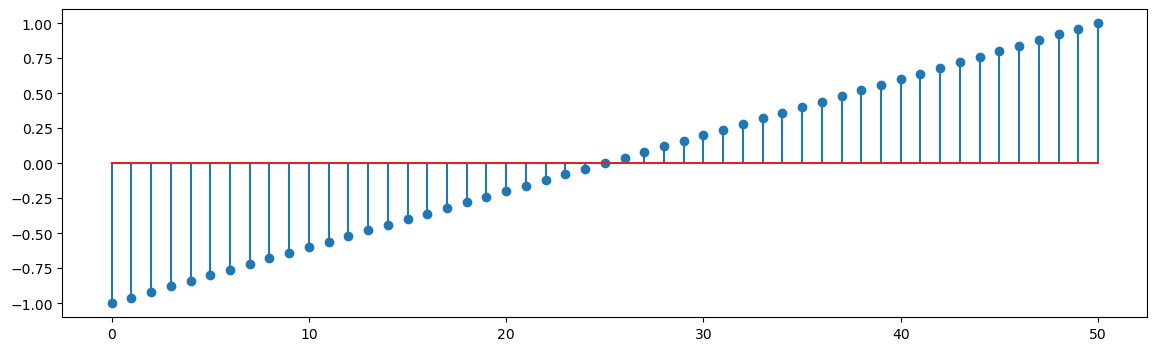

In [4]:
x = ramp(51)
plt.stem(x, use_line_collection=True);

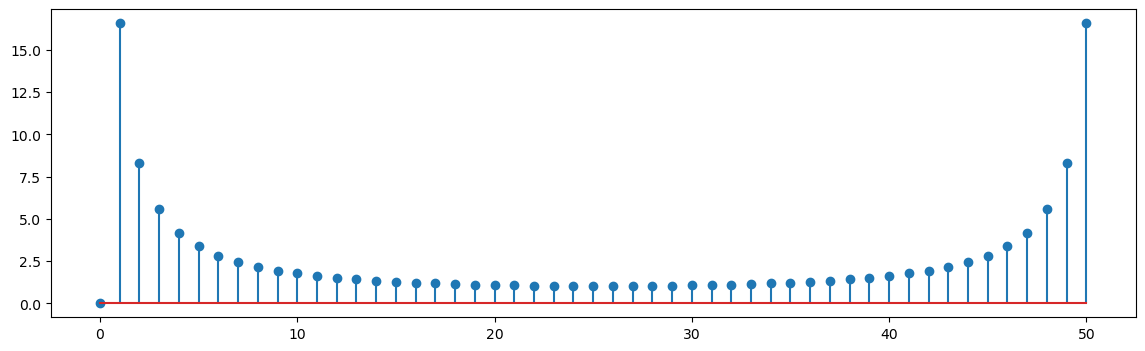

In [5]:
X = np.fft.fft(x)
plt.stem(abs(X), use_line_collection=True);

## 2. Positive and negative frequencies

The $k$-th DFT coefficient indicates the contribution (in amplitude and phase) to the input signal of a sinusoidal component of frequency

$$
    \omega_k = \frac{2\pi}{N}k.
$$

Because of the rotational symmetry of complex exponentials, a positive frequency $\omega$ between $\pi$ and $2\pi$ is equivalent to a negative frequency of $\omega - 2\pi$; this means that the "top half" of the DFT coefficients correspond to negative frequencies of the form

$$
    \omega_k = -\frac{2\pi}{N}(N - k) \quad k \ge \lceil N / 2 \rceil.
$$

When looking at the physical properties of a DFT decomposition it therefore may make more sense to plot the coefficients centered around zero with positive frequencies on the right and negative frequencies on the left, much in the same way as the usual custom with DTFT plots.

The reason why this is not usually done are many, including
 
 * since we are manipulating finite-length signals, the convention dictates that we start at index zero 
 * when dealing with real-valued data, the DFT is symmetric in magnitude, so the first half of the coefficients is enough
 * if we're looking for maxima in the magnitude, it's just easier to start at zero.
 
Nevertheless, when displaying spectral information, we will want to shift the spectrum and center it around zero. The following section implements a tool to do so.

### 2.1. Parity

There is a subtle point that we must take into account when shifting a DFT vector, namely, **we need to differentiate between odd- and even-length signals**. 

If we rearrange the DFT coefficients so that $X[0]$ becomes the center point, 

For odd-length vectors, we can write $N = 1 + 2L$ with $L = (N-1)/2 \in \mathbb{N}$, and the coefficients can be rearranged like so:

 * $X[0]$ becomes the center point
 * the coefficients $X[1]$ to $X[L]$ correspont to the positive frequencies, from $\omega_1 = 2\pi/N$ to $\omega_L = \pi - 2\pi/N$
 * the coefficients $X[L+1]$ to $X[N-1]$ correspont to the negative frequencies, from $\omega_{-1} = -2\pi/N$ to $\omega_{-L} = -\pi + 2\pi/N$
 
For even-length signals, on the other hand, $N/2$ is an integer and the maximum positive frequency is 

$$
    \omega_{N/2} = \frac{2\pi}{N}\frac{N}{2} = \pi.
$$

However, because of the periodicity of complex exponentials, a positive frequency of $\pi$ corresponds to a negative frequency of $-\pi$ and therefore, for even-length signals, $X[N/2]$ can either be considered the maximum-positive-frequency coefficients or the minimum-negative-frequency coefficients: the two coincide. When rearranging even-length DFT vectors, we therefore replicate $X[N/2]$ at the beginning of the set of negative freqency coefficeints in order to obtain a symmetric data vector. 

In [6]:
def dft_shift(X):
    N = len(X)
    L = len(X) // 2
    if (N % 2 == 0):
        # even-length: return N+1 values
        return np.concatenate((X[L:], X[:L+1]))
    else:
        # odd-length: return N values
        return np.concatenate((X[L+1:], X[:L+1]))

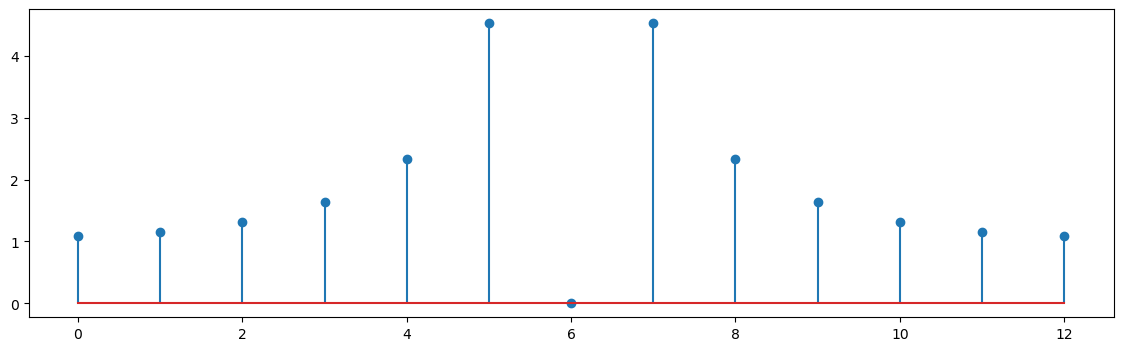

In [7]:
plt.stem(abs(dft_shift(np.fft.fft(ramp(13)))), use_line_collection=True);

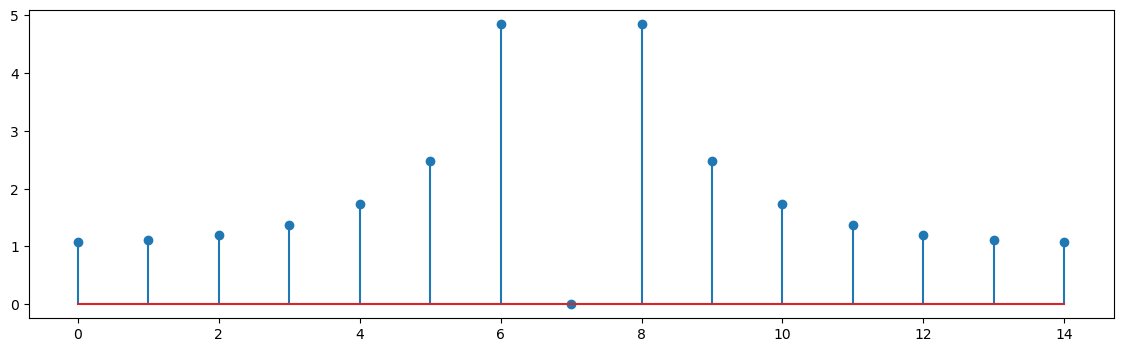

In [8]:
plt.stem(abs(dft_shift(np.fft.fft(ramp(14)))), use_line_collection=True);

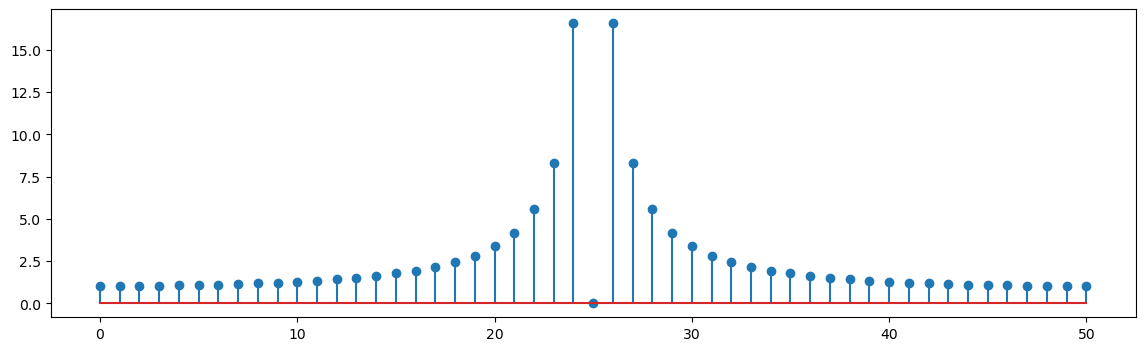

In [9]:
plt.stem(abs(dft_shift(X)), use_line_collection=True);

While the function does shift the vector, the indices are still from zero to $N-1$. Let's modify it so that we returs also the proper values for the indices:

In [10]:
def dft_shift(X):
    # use more compact notation: np.r_ and mod for parity
    L = len(X) // 2
    return np.arange(-L, L + 1), np.r_[ X[L+(len(X) % 2):], X[:L+1] ]

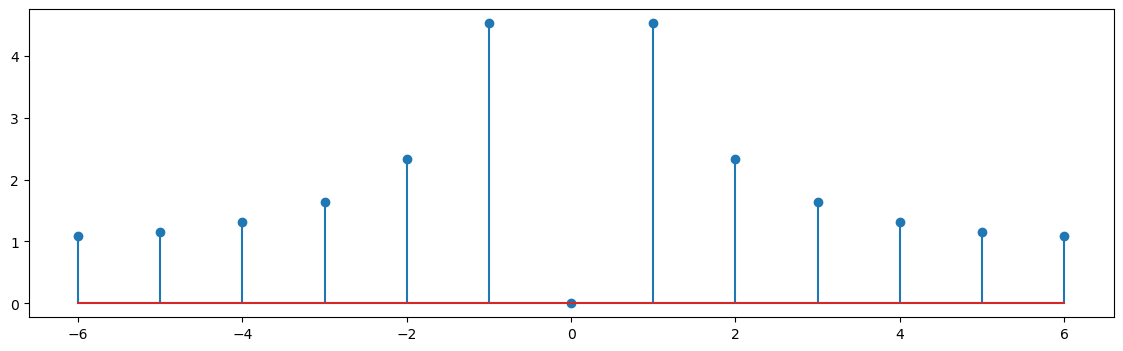

In [11]:
n, y = dft_shift(np.fft.fft(ramp(13)))
plt.stem(n, abs(y), use_line_collection=True);

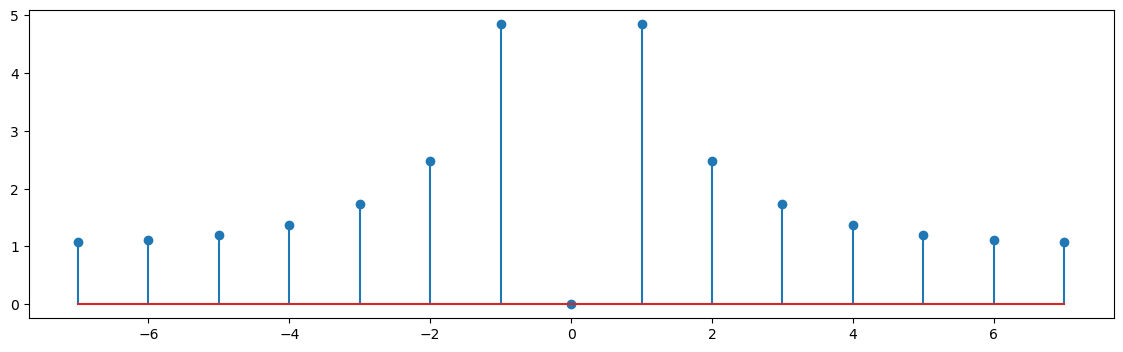

In [12]:
n, y = dft_shift(np.fft.fft(ramp(14)))
plt.stem(n, abs(y), use_line_collection=True);

## 3. Mapping the DFT index to real-world frequencies

The next step is to use the DFT to analyze real-world signals. As we have seen in previous examples, what we need to do is set the time interval between samples or, in other words, set the "clock" of the system. For audio, this is equivalent to the sampling rate of the file.

Here for instance is the sound of a piano note:

In [13]:
import IPython
from scipy.io import wavfile
Fs, x = wavfile.read("piano.wav")
IPython.display.Audio(x, rate=Fs)

In order to look at the spectrum of the sound file with a DFT we need to map the digital frequency "bins" of the DFT to real-world frequencies. 

The $k$-th basis function over $\mathbb{C}^N$ completes $k$ cycles over $N$ samples. If the time between samples is $1/F_s$, then the real-world frequency of the $k$-th basis function is cycles over time, namely $k(F_s/N)$.

Let's remap the DFT coefficients using the sampling rate:

In [14]:
def dft_map(X, Fs, shift=True):
    resolution = float(Fs) / len(X)
    if shift:
        n, Y = dft_shift(X)
    else:
        Y = X
        n = np.arange(0, len(Y))
    f = n * resolution
    return f, Y

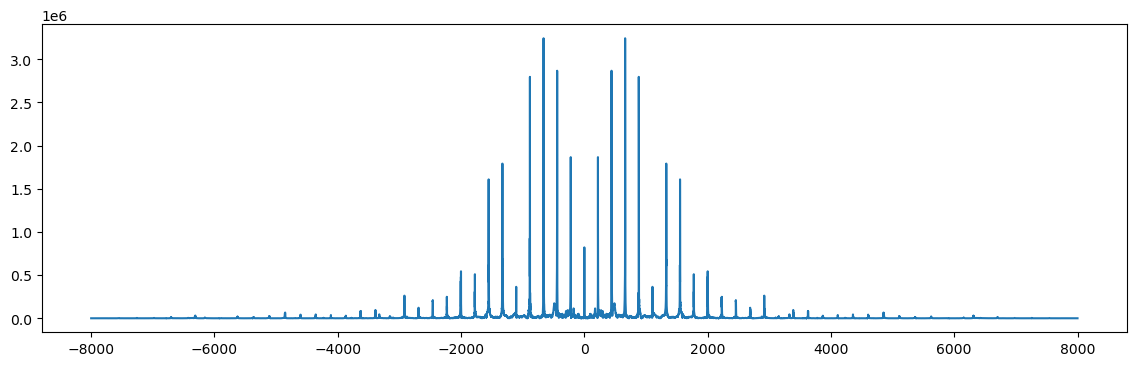

In [15]:
# let's cut the signal otherwise it's too big
x = x[:32768]
X = np.fft.fft(x);
f, y = dft_map(X, Fs)
plt.plot(f, abs(y));

The plot shows what a spectrum analyzer would display. The clear spectral lines indicate that some pattern is repeating periodically in the time-domain, which is the typical characteristic of musical sounds, and the repetition rate for the pattern determines the perceived *pitch* of the musical note. A pattern that repeats $f_0$ times per second will originate a spectrum with clear frequency lines at most integer multiples of $f_0$. 

To determine $f_0$, also called the fundamental frequency of the musical note,  we need to zoom in in the plot and find the first peak. This is one of the instances in which shifting the DFT does not help, since we'll be looking in the low-frequency range. So let's re-plot withouth the shift, but still mapping the frequencies:

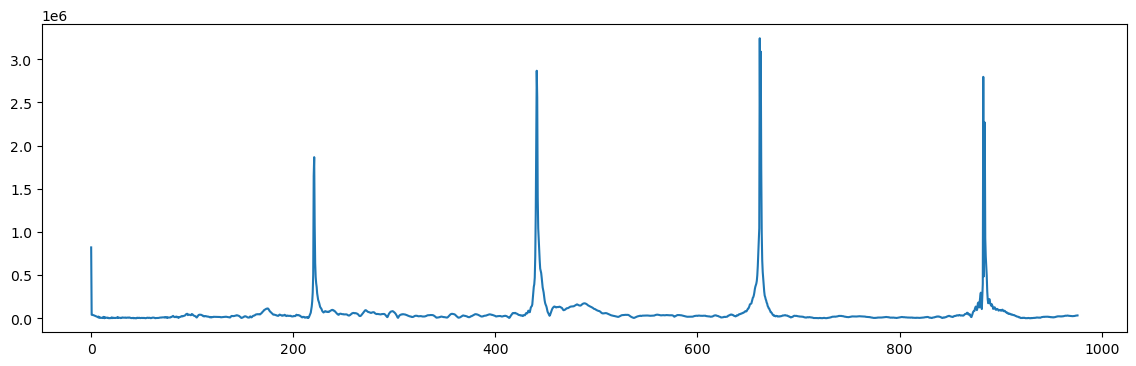

In [16]:
X = np.fft.fft(x);
f, y = dft_map(X, Fs, shift=False)
plt.plot(f[:2000], abs(y[:2000]));

We can see that the first peak is in the vicinity of 200Hz; to find the exact frequency (to within the resolution afforded by this DFT) let's find the location

In [18]:
dft_resolution = float(Fs)/ len(x)
print("DFT resolution is", dft_resolution, "Hz")

# let's search up to 300Hz
max_range = int(300 / dft_resolution)
ix = np.argmax(abs(y[:max_range]))
pitch = f[ix]
print("the note has a pitch of", pitch, "Hz")

DFT resolution is 0.48828125 Hz
the note has a pitch of 220.703125 Hz


so the note is a A, half the frequency of concert pitch.

## 4. Zero-padding

Since the resolution of a DFT depends on the length of the data vector, one may erroneously assume that, by *artificially* extending a given data set, the resulting resolution would improve. Note that here we're not talking about *collecting* more data; rather, we have a data set and we append zeros (or any other constant value) to the end of it. This extension is called zero-padding.

The derivation of why zero-padding does not increase the resolution is detailed in the book. Here we will just present a simple example. 

Assume we're in $\mathbb{C}^N$ with $N=256$. The resolution of the DFT in this space is 

$$
    \Delta = 2\pi/256 \approx 0.0245
$$

Let's build a signal with two sinusoids with frequencies more than $\Delta$ apart and let's look at the spectrum:

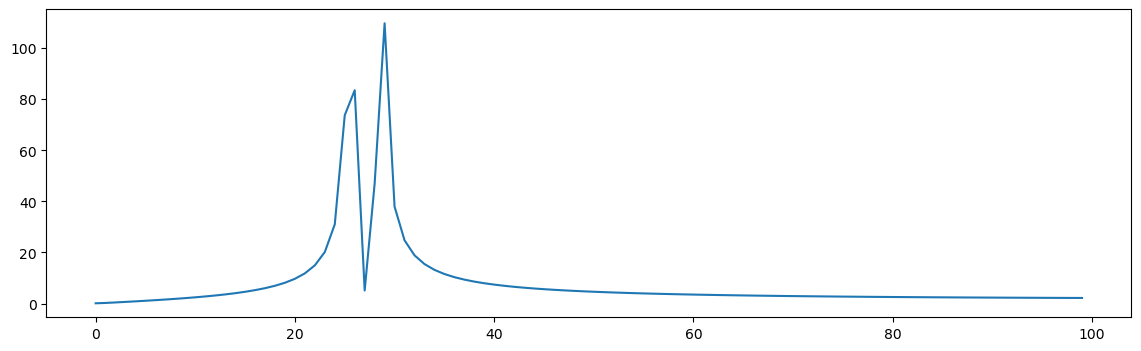

In [19]:
N = 256
Delta = 2*np.pi / N
n = np.arange(0, N)

# main frequency (not a multiple of the fundamental freq for the space)
omega = 2*np.pi / 10 

x = np.cos(omega * n) + np.cos((omega + 3*Delta) * n)
plt.plot(abs(np.fft.fft(x))[:100]);

we can tell the two frequencies apart and, if you zoom in on the plot, you will see that they are indeed three indices apart. Now let's build a signal with two frequencies that are less than $\Delta$ apart:

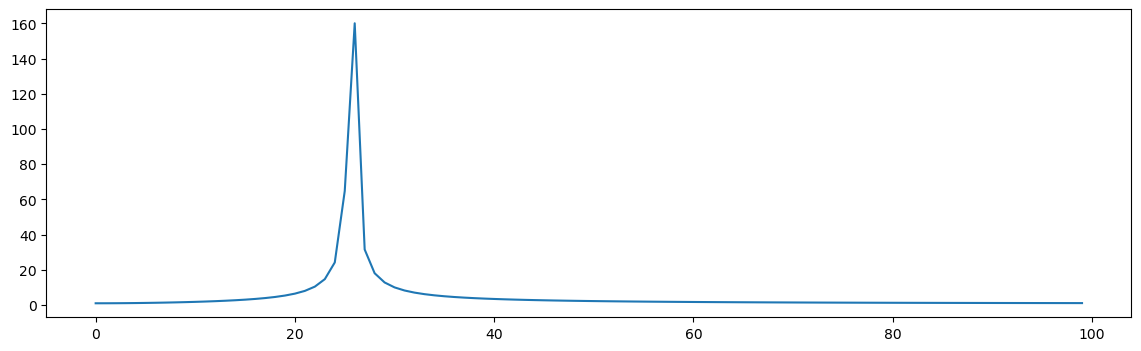

In [20]:
x = np.cos(omega * n) + np.cos((omega + 0.5*Delta) * n)
plt.plot(abs(np.fft.fft(x))[:100]);

The two frequencies cannot be resolved by the DFT. If you try to increase the data vector by zero padding, the plot will still display just one peak:

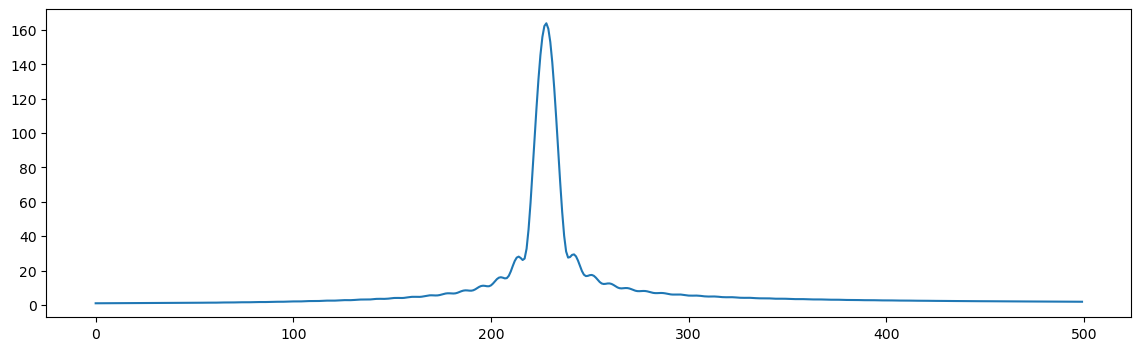

In [28]:
xzp = np.concatenate((x, np.zeros(2000)))
plt.plot(abs(np.fft.fft(xzp))[:500]);

# ---------------------------------




### Did you like this Notebook?
Yes, no, maybe? Why don't you give us some feedback using the completely anonymous form below? Thank you!

In [ ]:
from IPython.display import IFrame
IFrame('https://www.surveymonkey.com/r/NOTOSURVEY?notebook_set=COM303&notebook_id=DFTPlots', 600, 800)